In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def api_lookup(query, obj="works", cursor=None):
    
    if cursor is not None:
        cursor = f"cursor={cursor}"
    else:
        cursor = "cursor=*"
    
    base = "https://api.openalex.org/"
    perpage = "per-page=200"
    mailto = "mailto=erlanger@mcc-berlin.net"
    
    response = requests.get(f"{base}{obj}?{query}&{perpage}&{cursor}&{mailto}").json()

    results = response["results"]
    cursor = response["meta"]["next_cursor"]
    
    return results, cursor

def clean_results(df):
    
    df["doi"] = df["ids"].astype('str').str.extract(r"'doi': \'https:\/\/doi.org\/([^\']+)'")
    df["mag"] = df["ids"].astype('str').str.extract(r"'mag': \'(\d+)'")
    df["journal_name"] = df["host_venue"].apply(lambda x: x["display_name"].lower() if pd.notnull(x["display_name"]) else "N/A")
    df["journal_publisher"] = df["host_venue"].apply(lambda x: x["publisher"].lower() if pd.notnull(x["publisher"]) else "N/A")
    df["lcase_ttl"] = df["title"].str.lower()
    df["compressed_index"] = df["abstract_inverted_index"].apply(lambda x: x.keys() if pd.notnull(x) else "N/A")
    df["data_source"] = "openAlex"
    
    return df

def scroll(query, obj="works"):
    
    print(f"Query Submitted: {query}")
    
    allResults = []
    results, cursor = api_lookup(query, obj=obj)
    allResults.append(results)
    
    while cursor is not None:
        results, cursor = api_lookup(query, obj=obj, cursor=cursor)
        allResults.append(results)
    
    df = pd.concat([pd.DataFrame(x) for x in allResults], ignore_index=True)
    df = clean_results(df)
    df["q_params"] = query

    print(f"OpenAlex Response Size: {len(df.index)} Rows")
    
    return df

In [3]:
# Run Eval Queries #

q1 = "search=\"emission reduction\""
q2 = "search=\"capture and storage\""

df_q1 = scroll(q1)
df_q2 = scroll(q2)

Query Submitted: search="emission reduction"
OpenAlex Response Size: 9020 Rows
Query Submitted: search="capture and storage"
OpenAlex Response Size: 2893 Rows


In [4]:
# Regex Filtering for Complex Query 2 #

df_q2 = df_q2.loc[(df_q2["compressed_index"].str.join(' ').str.match(r"^(?=.*[cC](02|arbon))(?=.*[uU](tili.ation|sage)).*$")) | 
                  (df_q2["lcase_ttl"].str.match(r"^(?=.*[cC](02|arbon))(?=.*[uU](tili.ation|sage)).*$")) |
                  (df_q2["display_name"].str.match(r"^(?=.*[cC](02|arbon))(?=.*[uU](tili.ation|sage)).*$"))]

df_q2_ttl = df_q2.loc[df_q2["lcase_ttl"].str.match(r"^(?=.*[cC](02|arbon))(?=.*[uU](tili.ation|sage)).*$")]

In [5]:
# Import Control Groups #

def fix_controls(df):
    
    columns = ["nacsos_id","wos_id","lcase_ttl","authors","abstract","doi","pubyear","query_appears_in_title"]
    df["lcase_ttl"] = df["title"].str.lower().astype(str)
    df["pubyear"] = df["pubyear"].fillna(0).astype(int)
    df["doi"] = df["doi"].astype(str)
    
    df = df.loc[:,columns]
    
    df_ttl = df.loc[df["query_appears_in_title"]].drop_duplicates().reset_index(drop=True)
    df = df.loc[:,df.columns != "query_appears_in_title"].drop_duplicates().reset_index(drop=True)
    
    return df, df_ttl

df_ctrl1 = pd.read_csv("../engineEval/wos_dataset/wos_emission_query.csv")
df_ctrl2 = pd.read_csv("../engineEval/wos_dataset/wos_ccs_query.csv")
    
df_ctrl1, df_ctrl1_ttl = fix_controls(df_ctrl1)
df_ctrl2, df_ctrl2_ttl = fix_controls(df_ctrl2)

In [6]:
def overlap_eval(df1,df2):
    
    df_t = pd.merge(df1,df2, on="lcase_ttl", suffixes=(None,"_api")).drop("doi_api", axis=1).reset_index(drop=True)
    df_d = pd.merge(df1,df2, on="doi", suffixes=(None,"_api")).drop("lcase_ttl_api", axis=1).reset_index(drop=True)
    df_td = pd.concat([df_t,df_d])

    df_td = df_td.loc[:,["nacsos_id","wos_id","doi","pubyear","publication_year","lcase_ttl","journal_name","journal_publisher","q_params","data_source"]]\
                .drop_duplicates().reset_index(drop=True)
    
    results = {"wos_input" : len(df1.index),
               "api_input" : len(df2.index),
               "intersection_doi" : len(df_d.index),
               "intersection_title" : len(df_t.index),
               "intersection_doi_and_title" : len(df_td.index),
               "query_criteria" : df2["q_params"].iloc[0],
               "query_source" : df2["data_source"].iloc[0]
              }
    
    return results

toplineResults = []
yearlyResults = []

# Q1
toplineResults.append(overlap_eval(df_ctrl1,df_q1))

for i in [1995,2015,2021,2022]:
    
    year = overlap_eval(df_ctrl1.loc[df_ctrl1["pubyear"] == i],df_q1.loc[df_q1["publication_year"] == i])
    year.update({"year":i, "query":"1"})
    yearlyResults.append(year)

# Q2
toplineResults.append(overlap_eval(df_ctrl2,df_q2))

for i in [2015,2021,2022]:
    
    year = overlap_eval(df_ctrl2.loc[df_ctrl2["pubyear"] == i],df_q2.loc[df_q2["publication_year"] == i])
    year.update({"year":i, "query":"2"})
    yearlyResults.append(year)

df_results = pd.DataFrame(toplineResults).set_index(["query_source","query_criteria"])
df_results_yr = pd.DataFrame(yearlyResults).set_index(["query_source","query_criteria","year","query"])

<AxesSubplot:title={'center':'Query 2: CCS'}>

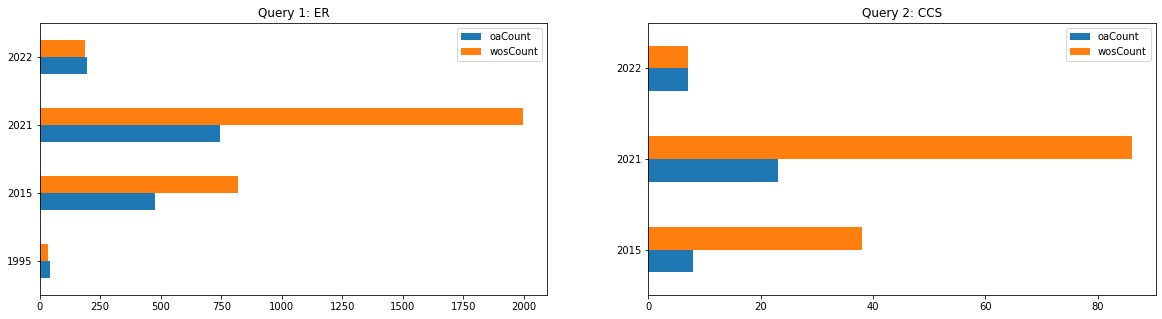

In [7]:
### Comparisons ###

# Year #

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

pd.concat([df_q1.loc[df_q1["publication_year"].isin([1995,2015,2021,2022])].groupby("publication_year").size(),
           df_ctrl1.loc[df_ctrl1["pubyear"].isin([1995,2015,2021,2022])].groupby("pubyear").size()], keys=["oaCount","wosCount"], axis=1)\
    .plot.barh(title="Query 1: ER", ax=axes[0])

pd.concat([df_q2.loc[df_q2["publication_year"].isin([1995,2015,2021,2022])].groupby("publication_year").size(),
           df_ctrl2.loc[df_ctrl2["pubyear"].isin([1995,2015,2021,2022])].groupby("pubyear").size()], keys=["oaCount","wosCount"], axis=1)\
    .plot.barh(title="Query 2: CCS", ax=axes[1])

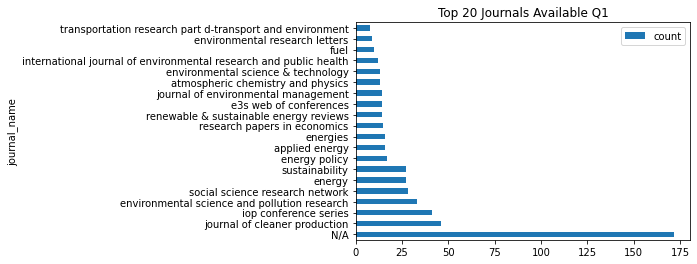

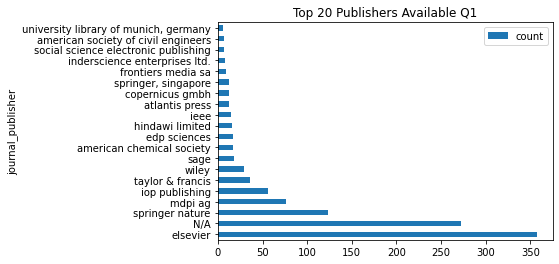

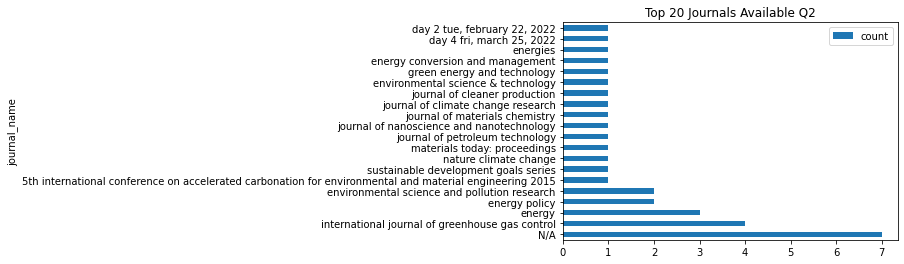

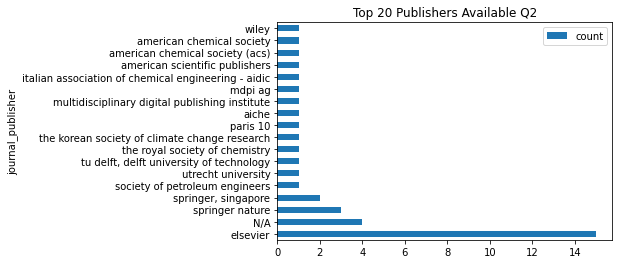

In [8]:
# Publication Names and Publishers #

def journal_name_plot(df, title=None):
    
    df_jn = pd.DataFrame(df.loc[df["publication_year"].isin([1995,2015,2021,2022])]\
    .groupby("journal_name").size(), columns=["count"])
    
    df_jn.sort_values(by=["count"], ascending=False).head(20).plot.barh(legend=True, title=title)
    
def journal_publisher_plot(df, title=None):
    
    df_jn = pd.DataFrame(df.loc[df["publication_year"].isin([1995,2015,2021,2022])]\
    .groupby("journal_publisher").size(), columns=["count"])
    
    df_jn.sort_values(by=["count"], ascending=False).head(20).plot.barh(legend=True, title=title)

journal_name_plot(df_q1, title="Top 20 Journals Available Q1")
journal_publisher_plot(df_q1, title="Top 20 Publishers Available Q1")

journal_name_plot(df_q2, title="Top 20 Journals Available Q2")
journal_publisher_plot(df_q2, title="Top 20 Publishers Available Q2")

<AxesSubplot:title={'center':'Query 2: WoS Control'}, ylabel='Has Abstract'>

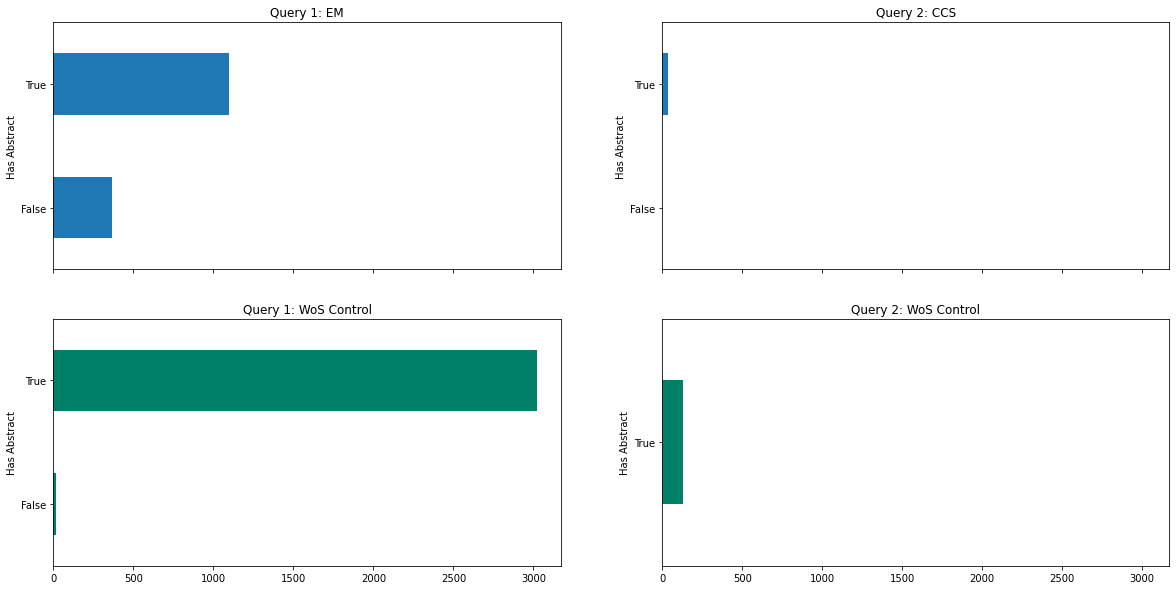

In [9]:
# Abstract Availability #

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True)

df_q1.loc[df_q1["publication_year"].isin([1995,2015,2021,2022])]\
    .groupby(~df_q1["abstract_inverted_index"].isnull()).size()\
    .plot.barh(xlabel="Has Abstract", title="Query 1: EM",  ax=axes[0,0])

df_q2.loc[df_q2["publication_year"].isin([1995,2015,2021,2022])]\
    .groupby(~df_q2["abstract_inverted_index"].isnull()).size()\
    .plot.barh(xlabel="Has Abstract", title="Query 2: CCS",  ax=axes[0,1])

df_ctrl1.loc[df_ctrl1["pubyear"].isin([1995,2015,2021,2022])]\
    .groupby((~df_ctrl1["abstract"].isnull()) & (len(df_ctrl1["abstract"]) > 0)).size()\
    .plot.barh(xlabel="Has Abstract", title="Query 1: WoS Control", colormap="summer", ax=axes[1,0])

df_ctrl2.loc[df_ctrl2["pubyear"].isin([1995,2015,2021,2022])]\
    .groupby((~df_ctrl2["abstract"].isnull()) & (len(df_ctrl2["abstract"]) > 0)).size()\
    .plot.barh(xlabel="Has Abstract", title="Query 2: WoS Control", colormap="summer", ax=axes[1,1])

In [10]:
df_results

wos_input  api_input  \
query_source query_criteria                                       
openAlex     search="emission reduction"        3160       9020   
             search="capture and storage"        134        122   

                                           intersection_doi  \
query_source query_criteria                                   
openAlex     search="emission reduction"                423   
             search="capture and storage"                18   

                                           intersection_title  \
query_source query_criteria                                     
openAlex     search="emission reduction"                  365   
             search="capture and storage"                  16   

                                           intersection_doi_and_title  
query_source query_criteria                                            
openAlex     search="emission reduction"                          484  
             search="capture and storage"                          20

In [35]:
df_results_yr

wos_input  api_input  \
query_source query_criteria               year query                         
openAlex     search="emission reduction"  1995 1             35         44   
                                          2015 1            819        475   
                                          2021 1           1995        745   
                                          2022 1            189        197   
             search="capture and storage" 2015 2             38          8   
                                          2021 2             86         23   
                                          2022 2              7          7   

                                                      intersection_doi  \
query_source query_criteria               year query                     
openAlex     search="emission reduction"  1995 1                     0   
                                          2015 1                    91   
                                          2021 1                   277   
                                          2022 1                    12   
             search="capture and storage" 2015 2                     1   
                                          2021 2                    15   
                                          2022 2                     0   

                                                      intersection_title  \
query_source query_criteria               year query                       
openAlex     search="emission reduction"  1995 1                       4   
                                          2015 1                     102   
                                          2021 1                     217   
                                          2022 1                       8   
             search="capture and storage" 2015 2                       3   
                                          2021 2                      12   
                                          2022 2                       0   

                                                      intersection_doi_and_title  
query_source query_criteria               year query                              
openAlex     search="emission reduction"  1995 1                               4  
                                          2015 1                             123  
                                          2021 1                             294  
                                          2022 1                              11  
             search="capture and storage" 2015 2                               3  
                                          2021 2                              15  
                                          2022 2                               0

<AxesSubplot:title={'center':'Query 2 Total Overlap'}>

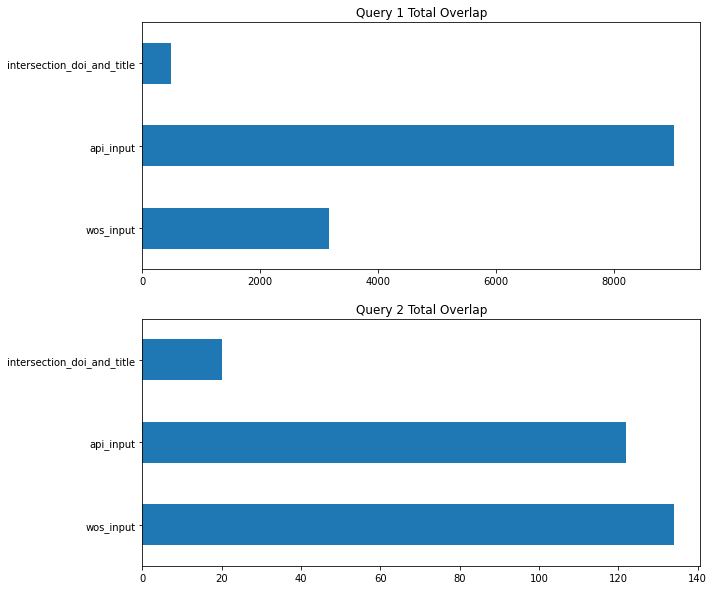

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

df_results.iloc[0,[0,1,4]].plot.barh(title="Query 1 Total Overlap", ax=axes[0])
df_results.iloc[1,[0,1,4]].plot.barh(title="Query 2 Total Overlap", ax=axes[1])

<AxesSubplot:title={'center':'Query 2'}>

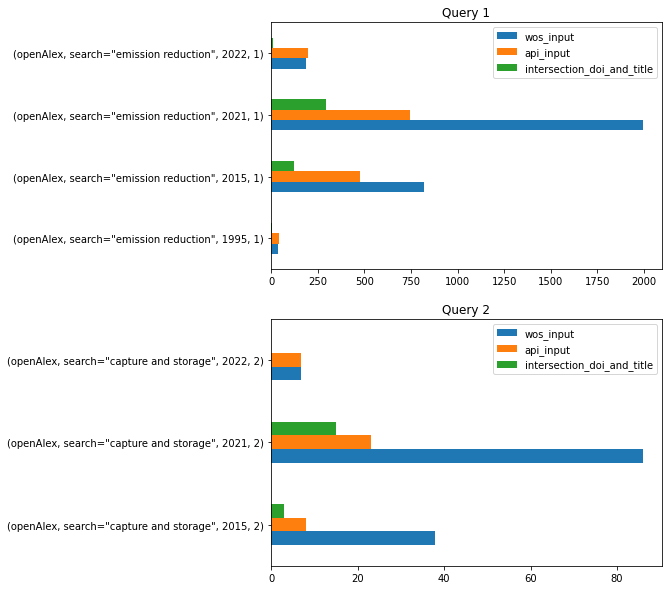

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,10))

df_results_yr.iloc[0:4,[0,1,4]].plot.barh(title="Query 1", xlabel="", ax=axes[0])
df_results_yr.iloc[4:,[0,1,4]].plot.barh(title="Query 2", xlabel="", ax=axes[1])